## Running the Water-Bodies Workflow
This workflow will run you through configuring and executing the [water-bodies](https://github.com/Terradue/ogc-eo-application-package-hands-on/tree/master/water-bodies) workflow. This workflow accepts a GeoTIF file and determines areas of water in the data based on NDWI (Normalised Difference Water Index) and the Otsu Threshold.
The workflow is defined in Common Workflow Language (CWL) so we will use the cwltool Python package to execute the workflow. Note, similar behaviour can also be seen when running directly from the command line.

In [1]:
# Import required packages
!pip install cwltool


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [2]:
# Define our desired inputs, we will use the open source Element84 dataset for this example run
import json
inputs = {
    "stac_items": [
      "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_10TFK_20210713_0_L2A",
      "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20220524_0_L2A"
    ],
    "aoi": "-121.399,39.834,-120.74,40.472",
    "epsg": "EPSG:4326",
    "bands": [
      "green",
      "nir"
    ]
}

# We will write our inputs to a new json file
with open("water-bodies_inputs.json", "w") as file:
    file.write(json.dumps(inputs, indent=2))

In [3]:
import cwltool.main
import cwltool.context

# Specify the output directory
out_dir = "outputs"

# Load the specific workflow with step identifier
workflow_uri = "water-bodies.cwl#water_bodies"

In [4]:
try:
    # Load and execute with given input file
    result = cwltool.main.main([
        "--outdir", out_dir,
        workflow_uri, 
        "water-bodies_inputs.json"
    ])
    print("Workflow completed with result:", result)
except Exception as e:
    print(f"Error: {e}")

INFO /home/tjellicoe/.asdf/installs/python/3.13.0/lib/python3.13/site-packages/ipykernel_launcher.py 3.1.20250715140722
INFO Resolved 'water-bodies.cwl#water_bodies' to 'file:///home/tjellicoe/Documents/OSPD/water-bodies.cwl#water_bodies'
INFO [workflow ] start
INFO [workflow ] starting step node_water_bodies
INFO [step node_water_bodies] start
INFO [workflow node_water_bodies] start
INFO [workflow node_water_bodies] starting step node_crop
INFO [step node_crop] start
WARNING [job node_crop] Skipping Docker software container '--memory' limit despite presence of ResourceRequirement with ramMin and/or ramMax setting. Consider running with --strict-memory-limit for increased portability assurance.
WARNING [job node_crop] Skipping Docker software container '--cpus' limit despite presence of ResourceRequirement with coresMin and/or coresMax setting. Consider running with --strict-cpu-limit for increased portability assurance.
INFO [job node_crop] /tmp/r0l09hjj$ docker \
    run \
    -i \


{
    "stac_catalog": {
        "location": "file:///home/tjellicoe/Documents/OSPD/outputs/os63hm3r",
        "basename": "os63hm3r",
        "class": "Directory",
        "listing": [
            {
                "class": "Directory",
                "location": "file:///home/tjellicoe/Documents/OSPD/outputs/os63hm3r/S2B_10TFK_20210713_0_L2A",
                "basename": "S2B_10TFK_20210713_0_L2A",
                "listing": [
                    {
                        "class": "File",
                        "location": "file:///home/tjellicoe/Documents/OSPD/outputs/os63hm3r/S2B_10TFK_20210713_0_L2A/S2B_10TFK_20210713_0_L2A.json",
                        "basename": "S2B_10TFK_20210713_0_L2A.json",
                        "size": 4882,
                        "checksum": "sha1$e74c29702b96c01957579e7d11b35d835356376b",
                        "path": "/home/tjellicoe/Documents/OSPD/outputs/os63hm3r/S2B_10TFK_20210713_0_L2A/S2B_10TFK_20210713_0_L2A.json"
                    },
   

INFO Final process status is success


Workflow completed with result: 0


In [10]:
combined_out_dir = out_dir + "/" + "os63hm3r" # copy the directory name from the `path` output in the above output field

In [11]:
# We can now check for the files in the local directory
# The workflow generates a STAC item pointing to the nested items
with open(f"{combined_out_dir}/catalog.json") as cat:
    catalog = json.load(cat)

print(json.dumps(catalog, indent=2))

{
  "type": "Catalog",
  "id": "catalog",
  "stac_version": "1.0.0",
  "description": "water-bodies",
  "links": [
    {
      "rel": "root",
      "href": "./catalog.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./S2B_10TFK_20210713_0_L2A/S2B_10TFK_20210713_0_L2A.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./S2A_10TFK_20220524_0_L2A/S2A_10TFK_20220524_0_L2A.json",
      "type": "application/json"
    }
  ]
}


In [13]:
# And we can list the individual STAC items generate
import os
from pathlib import Path
json_items = []
catalog_files = []
for link in catalog["links"]:
    if link["rel"] == "item":
        with open(os.path.join(combined_out_dir, link["href"])) as file:
            catalog_files.append(Path(os.path.join(combined_out_dir, link["href"])))
            json_items.append(json.load(file))

print("Found STAC items:")
for item in json_items:
    print("\t" + item["id"] + "  :  Containing asset: " + item["assets"]["data"]["href"])

Found STAC items:
	S2B_10TFK_20210713_0_L2A  :  Containing asset: otsu.tif
	S2A_10TFK_20220524_0_L2A  :  Containing asset: otsu.tif


In [14]:
!pip install pillow
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [15]:
# Select a Catalog file to load and view
catalog_file = catalog_files[0]
catalog_path = catalog_file.parents[0]
# Load assets

with open(catalog_file) as file:
    catalog_data = json.load(file)
assets = catalog_data["assets"]

first_asset_id = next(iter(assets))

first_asset = assets[first_asset_id]

asset_filename = first_asset["href"]

asset_path = os.path.join(catalog_path, asset_filename)

asset_path

'outputs/os63hm3r/S2B_10TFK_20210713_0_L2A/otsu.tif'

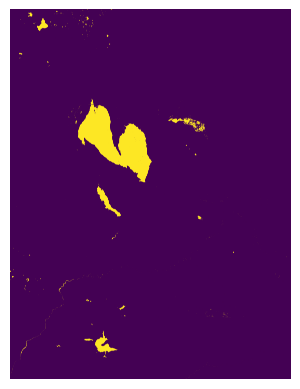

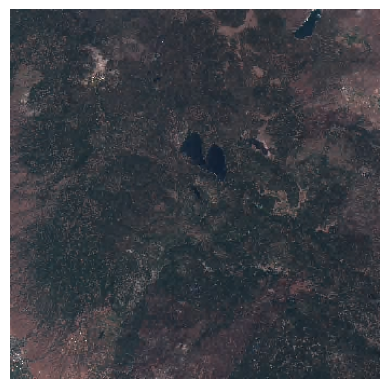

In [16]:
## We can now visualise the generated GeoTIFFs
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Set the data href
data_href = asset_path

# Fetch the image from the URL
image = Image.open(data_href)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Set the data href
data_href = asset_path

# Fetch the image from the URL
url = "https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/10/T/FK/2021/7/13/0/preview.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()